# Normalization errors for Δ47 measurements

This notebook is not designed to process real data, but to illustrate how Δ47 normalization errors behave, and to allow users to play around with different situations.

We start by defining "dummy" values for the normalization parameters (`a`,`b`,`c`). These values actually don't matter here, but they show up in the calculations.

In [35]:
import numpy as np
from numpy.linalg import inv
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

# true values for a,b,c
a,b,c = 0.9, 1e-4, -0.85

Now we define a certain value for Δ47 reproducibility, e.g. 15 ppm:

In [36]:
# session-wide D47 reproducibility
rD47 = 0.015

Now we define the number of anchor measurements and the composition of each anchor, as well as some unknown measurements:

In [37]:
# define anchor measurements
anchors = []
anchors += [{'name':'ETH-1', 'd47':+17, 'D47':0.258, 'N':10}]
anchors += [{'name':'ETH-2', 'd47':-11, 'D47':0.256, 'N':10}]
anchors += [{'name':'ETH-3', 'd47':+17, 'D47':0.691, 'N':10}]

# define unknown measurements
unknowns = []
unknowns += [{'name':'ETH-4', 'd47':-11, 'D47':0.513, 'N':9}]
unknowns += [{'name':'IAEA-C1', 'd47':+17, 'D47':0.360, 'N':4}]
unknowns += [{'name':'IAEA-C2', 'd47':0, 'D47':0.716, 'N':3}]
unknowns += [{'name':'MERCK', 'd47':-40, 'D47':0.573, 'N':4}]

Now we solve the least-squares regression to compute best-fit values of `(a,b,c)` and their covariance matrix `CM`:

In [38]:
# reorganize the data (bookkeeping, boring)
data = [{
    'name':x['name'],
    'd47':x['d47'],
    'D47':x['D47'],
    'D47raw':a*x['D47'] + b*x['d47'] + c,
    } for x in anchors for k in range(x['N'])]

# solve least-squares regression
A = np.array([[x['D47'], x['d47'], 1.] for x in data])
Y = np.array([[x['D47raw']] for x in data])
M = inv( A.T @ A ) @ A.T
a_fit, b_fit , c_fit = ( M @ Y ).T[0,:]
CM = inv( A.T @ A )*rD47**2

# check that we get accurate values of a, b, c
print(f'a_fit = {a_fit:.3f}      (true value is {a:.3f}).')
print(f'b_fit = {b_fit:.2e}   (true value is {b:.2e}).')
print(f'c_fit = {c_fit:.3f}     (true value is {c:.3f}).')

a_fit = 0.900      (true value is 0.900).
b_fit = 1.00e-04   (true value is 1.00e-04).
c_fit = -0.850     (true value is -0.850).


We can now write a function to compute the normalization error as a function of `CM`, `d47`, and `D47`:

In [39]:
def norm_error(CM, d47, D47):
    return np.sqrt(
        CM[0,0]*D47**2
        + CM[1,1]*d47**2
        + CM[2,2]
        + 2*CM[0,1]*D47*d47
        + 2*CM[0,2]*D47
        + 2*CM[1,2]*d47
        )/a

It's now straightforward to map of this error in `(d47, D47)` space:

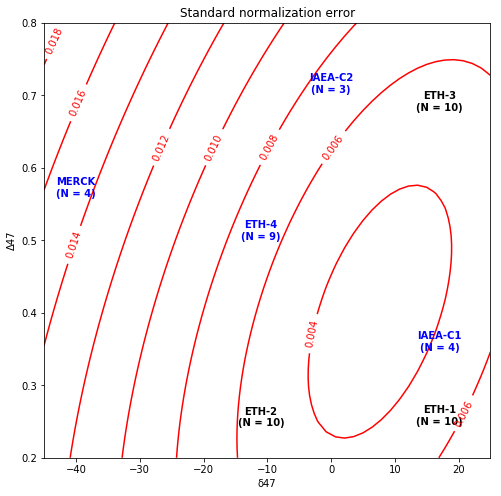

In [40]:
d47, D47 = np.meshgrid(np.linspace(-45,+25),np.linspace(0.2,0.8))

plt.figure(figsize = (8,8))
cs = plt.contour(d47, D47, norm_error(CM, d47, D47), colors='r')
plt.clabel(cs)

for x in anchors:
    plt.text(x['d47'], x['D47'], f"{x['name']}\n(N = {x['N']})",
        va = 'center', ha = 'center', weight = 'bold')

for x in unknowns:
    plt.text(x['d47'], x['D47'], f"{x['name']}\n(N = {x['N']})",
        va = 'center', ha = 'center', weight = 'bold', color = 'b')

plt.xlabel('δ47')
plt.ylabel('Δ47')
plt.title('Standard normalization error')
plt.show()

We can also compare “inherent” and “normalization“ errors (noted `iSE`, `nSE`) for each unknown and compute their total standard errors (`tSE`):


             Unknown    iSE    nSE    tSE
--------------------  -----  -----  -----
               ETH-4  0.005  0.007  0.009
             IAEA-C1  0.007  0.004  0.009
             IAEA-C2  0.009  0.007  0.011
               MERCK  0.007  0.015  0.017
--------------------  -----  -----  -----



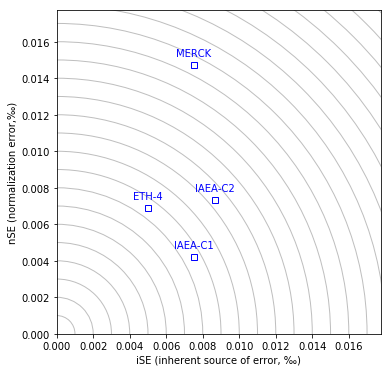

In [41]:
plt.figure(figsize = (6,6))
plt.subplots_adjust(.2,.2,.95,.95)

print()
print('             Unknown    iSE    nSE    tSE')
print('--------------------  -----  -----  -----')


xmax = -1
for x in unknowns:
    inherent_error = rD47 / np.sqrt(x['N'])
    normalization_error = norm_error(CM, x['d47'], x['D47'])
    plt.plot(inherent_error, normalization_error, 'ws', mec='b', mew=1)
    plt.text(inherent_error, normalization_error, f"{x['name']}\n\n",
        va = 'center', ha = 'center', color = 'b')
    
    print(f"{x['name']:>20}  {inherent_error:.3f}  {normalization_error:.3f}  {np.sqrt(inherent_error**2 + normalization_error**2):.3f}")
    
    xmax = max(xmax, inherent_error)
    xmax = max(xmax, normalization_error)

print('--------------------  -----  -----  -----\n')

N = int(np.floor(np.sqrt(2)*(1000*xmax + 3)**2))
for e in np.linspace(0.001, 0.001*N, N):
    plt.gca().add_artist(
        Ellipse(
            xy = (0,0), width = 2*e, height = 2*e,
            lw = 1, fc = 'none', ec = [.75]*3, ls = '-', zorder = -100 )
            )

plt.axis([0,xmax+0.003,0,xmax+0.003])
plt.xlabel('iSE (inherent source of error, ‰)')
plt.ylabel('nSE (normalization error,‰)')
plt.show()